In [ ]:
import torch
import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
pt_files = sorted(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/merfish_brain_preprocessed/*"))
for i, file in tqdm(enumerate(pt_files)):
    # patient_c = file.split("/")[-1].split("_")[1]
    slide_name = file.split("/")[-1][:-3]
    graphs = torch.load(file, weights_only=False)
    X = []
    for k in range(1, len(graphs)):
        X.append(graphs[k].X.squeeze(1).tolist())
    pos = graphs[0].X.float().numpy()
    X = np.array(X)
    adata = anndata.AnnData(X)
    adata.obsm['spatial'] = pos
    # adata.obs['cell_type'] = graphs[0].cell_type
    # adata.uns['reccurence'] = graphs[0].recurrence
    # adata.uns['outcome'] = graphs[0].primary_outcome
    adata.write_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/adata/merfish-brain/"+slide_name+".h5ad")

In [14]:
graphs[0].cell_types

array(['Cytotrophoblast', 'Decidua', 'Fibroblasts', 'Hoffbauer cells',
       'Mesenchymal cells', 'Myometrial cells', 'Plasma cells',
       'Smooth muscle (endothelial)', 'Syncytiotrophoblast'], dtype=object)

In [12]:
import torch
import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
graphs = torch.load("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich_placenta/02021424.pt", weights_only=False)
var = pd.Index(pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich.csv")["Unnamed: 0"])
X = []
for k in range(1, len(graphs)):
    X.append(graphs[k].X.squeeze(1).tolist())
pos = graphs[0].X.float().numpy()
X = np.array(X)
adata = anndata.AnnData(X)
adata.obsm['spatial'] = pos
adata.var.index = var
adata.write_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/"+"placenta"+".h5ad")
# for i, file in tqdm(enumerate(pt_files)):
#     # patient_c = file.split("/")[-1].split("_")[1]
#     slide_name = file.split("/")[-1][:-3]
#     graphs = torch.load(file, weights_only=False)
    

In [11]:
pd.Index(pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich.csv")["Unnamed: 0"])

Index(['GNB1', 'LRRC47', 'KIAA2013', 'UBR4', 'MICOS10', 'TRIM62', 'AGO4',
       'PRDX1', 'LRRC41', 'JUN',
       ...
       'TBC1D22A', 'CSF2RA', 'SLC25A6', 'TMSB4X', 'PRDX4', 'TIMP1', 'ACSL4',
       'THOC2', 'OCRL', 'IKBKG'],
      dtype='object', name='Unnamed: 0', length=200)

0          GNB1
1        LRRC47
2      KIAA2013
3          UBR4
4       MICOS10
         ...   
195       TIMP1
196       ACSL4
197       THOC2
198        OCRL
199       IKBKG
Name: Unnamed: 0, Length: 200, dtype: object

In [19]:
var = pd.Index(pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/merfish_brain/H18.06.006.MTG.250.expand.rep1.genes.csv").values.T[0])


In [ ]:
var.shape

In [ ]:
import torch
data = torch.load("data/merfish_brain_preprocessed/H20_30_001_STG_250_unexpand_rep1.pt")

In [ ]:
torch.log1p(data[1].X*10000)

In [ ]:
df["Num cells"]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("data/Spatial transcriptomics datasets - Pretraining.csv")

data = {}
for o, n in zip(df["Organ/Tissue"], df["Num cells"]):
    data[o] = data.get(o, 0) + n

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dictionary (replace with your actual data)

# Sort the data
organs_sorted = [x for _, x in sorted(zip(data.values(), data.keys()), reverse=True)]
counts_sorted = sorted(data.values(), reverse=True)

# Format numbers
def human_format(num):
    if num >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'
    elif num >= 1_000:
        return f'{num / 1_000:.0f}K'
    return str(num)

# Plotting
sns.set_context("talk")
sns.set_style("white")
plt.figure(figsize=(8, 8))
colors = sns.color_palette("icefire", len(data))
bars = plt.barh(organs_sorted, counts_sorted, color=colors)

# Add text labels
for bar, value in zip(bars, counts_sorted):
    plt.text(bar.get_width() + max(counts_sorted) * 0.01,
             bar.get_y() + bar.get_height() / 2,
             human_format(value),
             va='center', fontsize=12)

plt.xlabel("Number of samples")
plt.gca().invert_yaxis()
plt.grid(False)
plt.box(False)
plt.tight_layout()
plt.show()


In [32]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import numpy as np
from glob import glob

data = torch.load("data/sea_graphs_model_with_custom_layer_full.pt", weights_only=False)


In [41]:
clusters = []
embeddings = []
nmi = []
for i in tqdm(range(len(data))):
    X = data[i].X.cpu().numpy()
    X = X[:, X.shape[1]//2:]
    y_true = data[i].cell_type.cpu().numpy()
    kmeans = KMeans(n_clusters=len(np.unique(y_true)))
    y_pred = kmeans.fit_predict(X)
    nmi.append(normalized_mutual_info_score(y_true, y_pred))
    # if(nmi>max_nmi):
    #     clusters = y_pred
    #     embeddings = X
    #     max_nmi = nmi
    #     idx = i
nmi = np.array(nmi)

100%|██████████| 69/69 [00:04<00:00, 16.56it/s]


array([11, 54, 30, 66, 46])

In [42]:
print(np.argsort(nmi)[-5:])
print(nmi[np.argsort(nmi)[-5:]])

[11 54 30 66 46]
[0.94741269 0.94787363 0.95454402 0.95842282 0.96025082]


In [33]:
saved_data = []
tissues = glob("data/pretraining/sea_preprocessed/*")

for i in [11, 54, 30, 46]:
    copy_data = data[i]#.copy()
    copy_data.cell_type = copy_data.cell_types[copy_data.cell_type.cpu()]
    slide_name = tissues[i].split("/")[-1][:-3]
    copy_data.pos = anndata.read_h5ad(f"/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/sea/{slide_name}.h5ad").obsm['spatial']#.values
    saved_data.append(copy_data)

In [37]:
saved_data[0].keys()

['num_nodes',
 'cell_types',
 'X',
 'edge_index',
 'center_coord',
 'biomarker_expression',
 'cell_id',
 'cell_type',
 'voronoi_polygon',
 'edge_type',
 'pos',
 'distance',
 'y']

In [41]:
torch.save(saved_data, "/gpfs/gibbs/pi/krishnaswamy_smita/hm638/sea_with_pos.pt")

In [2]:
import torch
torch.load("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/sea_with_pos.pt")

/tmp/ipykernel_675783/857063508.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/sea_with_pos.pt")


[Data(edge_index=[2, 36879], voronoi_polygon=[5275], cell_id=[5275], center_coord=[5275, 2], cell_type=[5275], biomarker_expression=[5275], distance=[36879], edge_type=[36879], num_nodes=5275, cell_types=[24], X=[5275, 256], y=[3642], pos=[5275, 2]),
 Data(edge_index=[2, 25444], voronoi_polygon=[3642], cell_id=[3642], center_coord=[3642, 2], cell_type=[3642], biomarker_expression=[3642], distance=[25444], edge_type=[25444], num_nodes=3642, cell_types=[24], X=[3642, 256], y=[6231], pos=[3642, 2]),
 Data(edge_index=[2, 33784], voronoi_polygon=[4834], cell_id=[4834], center_coord=[4834, 2], cell_type=[4834], biomarker_expression=[4834], distance=[33784], edge_type=[33784], num_nodes=4834, cell_types=[24], X=[4834, 256], y=[5747], pos=[4834, 2]),
 Data(edge_index=[2, 34597], voronoi_polygon=[4951], cell_id=[4951], center_coord=[4951, 2], cell_type=[4951], biomarker_expression=[4951], distance=[34597], edge_type=[34597], num_nodes=4951, cell_types=[24], X=[4951, 256], y=[6859], pos=[4951, 2

In [40]:
for i in saved_data:
    print(i.pos.shape[0] == i.num_nodes)

True
True
True
True


In [9]:
data[11].cell_types[data[11].cell_type.cpu().numpy()]

array(['L2/3 IT', 'Astrocyte', 'Microglia-PVM', ..., 'Sncg',
       'Oligodendrocyte', 'L2/3 IT'], dtype=object)

In [17]:
data[11]

Data(edge_index=[2, 36879], voronoi_polygon=[5275], cell_id=[5275], center_coord=[5275, 2], cell_type=[5275], biomarker_expression=[5275], distance=[36879], edge_type=[36879], num_nodes=5275, cell_types=[24], X=[5275, 256], y=[3642])

In [ ]:
import anndata
from glob import glob

'data/pretraining/sea_preprocessed/H21.33.019_1.pt'

In [ ]:
anndata.read_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/sea/H21.33.019_1.h5ad")

AnnData object with n_obs × n_vars = 5275 × 180
    obs: 'cell_type'
    obsm: 'spatial'

In [12]:
raw_list = glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/sea/*")

In [84]:
raw_list[11]

'/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/sea/H20.33.015_0.h5ad'

In [76]:
saved_data = []

In [85]:
raw_adata = anndata.read_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/sea_raw/H20.33.015.h5ad")
adata = raw_adata[raw_adata.obs['Section'] == raw_adata.obs['Section'].unique()[0]].copy() 
copy_data = data[11]
copy_data.pos = adata.obsm['spatial']
copy_data.cell_type = adata.obs['Subclass'].values
saved_data.append(copy_data)

In [92]:
copy_data.y

array(['Braak III', 'Braak III', 'Braak III', ..., 'Braak III',
       'Braak III', 'Braak III'], dtype=object)

In [87]:
torch.save(saved_data, "data/sea_with_pos.pt")

In [89]:
for i in torch.load("data/sea_with_pos.pt"):
    print(i.X.shape[0] == len(i.voronoi_polygon))

True
True
True
True
True


/tmp/ipykernel_383961/1307082452.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  for i in torch.load("data/sea_with_pos.pt"):


In [93]:
copy_data.cell_types

array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype=object)

In [ ]:
import phate
import matplotlib.pyplot as plt
import seaborn as sns

# phate_operator = phate.PHATE(n_components=2)
# phate_2d = phate_operator.fit_transform(embeddings)

# Plot
sns.set_context("paper")
sns.set_style("white")
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.8)
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.title("PHATE Plot of Embeddings")
plt.axis('off')  # Optional: turn off axes
plt.tight_layout()
plt.show()


In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# embeddings: shape (n_samples, n_features)
# clusters: shape (n_samples,), e.g., cluster labels like 0, 1, 2...

# UMAP projection to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_2d = umap_model.fit_transform(embeddings)

# Plot
sns.set_context("paper")
sns.set_style("white")
plt.figure(figsize=(6, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.8)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Plot of Embeddings")
plt.axis('off')  # Optional: remove axes for a cleaner look
plt.tight_layout()
plt.show()

In [1]:
import anndata
adata = anndata.read_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/melanoma/R12C3.h5ad")

In [2]:
# Remove a variable (gene/feature) named "GeneX"
adata = adata[:, adata.var_names != "HLA class 1 A, B, and C, Na-K-ATPase"]
adata = adata[:, adata.var_names != "HLA DPDQDR"]
adata = adata[:, adata.var_names != "beta-tubulin"]
adata = adata[:, adata.var_names != "Podoplanin"]
adata = adata[:, adata.var_names != "Granzyme B"]
adata = adata[:, adata.var_names != "Vimentin"]


In [ ]:
adata.var.index

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
for i in range(100):
# Get one random row
    row_idx = np.random.randint(adata.n_obs)
    row = adata.X[row_idx].A1 if hasattr(adata.X[row_idx], "A1") else adata.X[row_idx]

    # Filter out zero values
    nonzero_indices = np.where(row != 0)[0]

    # Pick up to 10 random nonzero columns
    selected_indices = np.random.choice(nonzero_indices, min(10, len(nonzero_indices)), replace=False)
    col_names = adata.var.index[selected_indices]
    selected_values = row[selected_indices]
    selected_values = selected_values[selected_values!=0]
    # Randomly mask a few (e.g., 3 or less if fewer bars)
    num_mask = min(3, len(selected_values))
    mask_indices = np.random.choice(range(len(selected_values)), num_mask, replace=False)

    # Set up plot
    sns.set_style("white")
    sns.set_context("talk")
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    colors = sns.color_palette("Set2", len(selected_values))
    bar_width = 0.8

    # Plot 1: Masked
    for i, (name, value) in enumerate(zip(col_names, selected_values)):
        if i in mask_indices:
            axs[0].bar(name, value, color='white', edgecolor='black', hatch='///', width=bar_width,
                    label='Missing' if i == mask_indices[0] else "")
        else:
            axs[0].bar(name, value, color=colors[i], width=bar_width,
                    label='True value' if i == 0 else "")
    axs[0].tick_params(axis='x', rotation=90)

    # Plot 2: Ground truth
    for i, (name, value) in enumerate(zip(col_names, selected_values)):
        axs[1].bar(name, value, color=colors[i], width=bar_width)
    axs[1].tick_params(axis='x', rotation=90)

    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()


In [ ]:
adata.var.index

In [ ]:
import torch
import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
pt_files = sorted(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/sea/*"))
for i, file in tqdm(enumerate(pt_files)):
    # patient_c = file.split("/")[-1].split("_")[1]
    slide_name = file.split("/")[-1][:-5]
    adata = anndata.read_h5ad(file)
    adata.var.index = anndata.read_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/sea_raw/H20.33.001.h5ad").var.index
    adata.write_h5ad(file)
    # X = []
    # for k in range(1, len(graphs)):
    #     X.append(graphs[k].X.squeeze(1).tolist())
    # pos = graphs[0].X.float().numpy()
    # X = np.array(X)
    # adata = anndata.AnnData(X)
    # adata.obsm['spatial'] = pos
    # # adata.obs['cell_type'] = graphs[0].cell_type
    # # adata.uns['reccurence'] = graphs[0].recurrence
    # # adata.uns['outcome'] = graphs[0].primary_outcome
    # adata.write_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/adata/merfish-brain/"+slide_name+".h5ad")

In [1]:
import torch
import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
graphs = torch.load("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich_placenta/02011412.pt", weights_only = False)
X = []
for k in range(1, len(graphs)):
    X.append(graphs[k].X.squeeze(1).tolist())
pos = graphs[0].X.float().numpy()
X = np.array(X)
adata = anndata.AnnData(X)
adata.obsm['spatial'] = pos
adata.write_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/")

In [28]:
from glob import glob
import torch
max_size = 0
max_index = -1
for k, file in enumerate(glob("data/pretraining/sea_preprocessed/*")):
    graphs = torch.load(file, weights_only=False)
    if(max_size < graphs[0].num_nodes):
        max_size = graphs[0].num_nodes
        max_index = k

In [29]:
glob("data/pretraining/sea_preprocessed/*")[max_index]

'data/pretraining/sea_preprocessed/H20.33.001_1.pt'

In [30]:
embeddings = torch.load("data/sea_graphs_model_with_custom_layer_full_ortho.pt", weights_only=False)[max_index].X
embeddings = embeddings.cpu().numpy()

In [31]:
import anndata 
adata = anndata.read_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/sea_raw/H20.33.001.h5ad")
adata = adata[adata.obs['Section'] == adata.obs['Section'].unique()[1]].copy()
adata.obs.organ = "brain"
cell_type = adata.obs['Subclass']


In [32]:
import numpy as np
np.save("data/saved_reps.npy", {'x':embeddings, 'cell_type':np.array(list(cell_type.values)), 'organ':np.array(["brain" for i in range(len(cell_type))])})

[]

In [33]:
max_size = 0
max_index = -1
for k, file in enumerate(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/space-gm/preprocessed/charville/*")):
    graphs = torch.load(file, weights_only=False)
    if(max_size < graphs[0].num_nodes):
        max_size = graphs[0].num_nodes
        max_index = k

In [34]:
glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/space-gm/preprocessed/charville/*")[max_index]

'/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/space-gm/preprocessed/charville/Charville_c002_v001_r001_reg184.pt'

In [35]:
embeddings = torch.load("data/space-gm/charville_graphs_model_with_custom_layer_full_ortho.pt", weights_only=False)[max_index].X
embeddings = embeddings.cpu().numpy()

In [36]:
import pandas as pd
cell_types = pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/space-gm/raw/charville/Charville_c002_v001_r001_reg184.cell_types.csv")
other_files = pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/space-gm/raw/charville/Charville_c002_v001_r001_reg184.cell_data.csv")
cell_type = cell_types.iloc[:, 1:].values.T[0][np.argsort(other_files.CELL_ID)]


In [37]:
cell_type

array(['Tumor 5', 'Tumor 4', 'Tumor 6 / DC', ..., 'Granulocyte',
       'Tumor 4', 'Tumor 6 / DC'], dtype=object)

In [38]:
np.save("data/saved_reps_2.npy", {'x':embeddings, 'cell_type':cell_type, 'organ':np.array(["colon" for i in range(len(cell_type))])})


In [43]:
glob("data/merfish_lung_preprocessed/*").index("data/merfish_lung_preprocessed/MSa29_06.pt")

112

In [44]:
embeddings = torch.load("data/merfish_lung_model_with_custom_layer_full_ortho.pt", weights_only=False)[112].X
embeddings = embeddings.cpu().numpy()

In [47]:
df = pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/merfish_lung/merfish_lung/ACD_stemimmunity.csv")
df = df[df["slide"] == "MSa29_06"]
cell_type = df['type'].values

In [50]:
np.save("data/saved_reps_3.npy", {'x':embeddings, 'cell_type':cell_type, 'organ':np.array(["lung" for i in range(len(cell_type))])})


In [59]:
x = np.load("data/saved_reps.npy", allow_pickle=True)
x1 = np.load("data/saved_reps_1.npy", allow_pickle=True)
x2 = np.load("data/saved_reps_2.npy", allow_pickle=True)
x3 = np.load("data/saved_reps_3.npy", allow_pickle=True)

In [58]:
X = np.vstack([x.item()['x'], x1.item()['x'], x2.item()['x'], x3.item()['x']])
organ = np.hstack([x.item()['organ'], x1.item()['organ'], x2.item()['organ'], x3.item()['organ']])
cell_type = np.hstack([x.item()['cell_type'], x1.item()['cell_type'], x2.item()['cell_type'], x3.item()['cell_type']])
np.save("data/saved_reps.npy", {'x':X, 'cell_type':cell_type, 'organ':organ})


In [8]:
import numpy as np

data = np.load("data/saved_reps_large.npy", allow_pickle=True).item()

In [10]:
data.keys()

dict_keys(['x', 'cell_type', 'tissue', 'technology', 'organ'])

In [13]:
del data['x']
del data['cell_type']

In [14]:
data.keys()

dict_keys(['tissue', 'technology', 'organ'])

In [18]:
import pandas as pd
df = pd.DataFrame(data)

In [22]:
df.value_counts()

tissue  technology  organ   
4       merfish     skin        50884
11      xenium      colon       47327
2       merfish     liver       34416
5       merfish     prostate    34057
6       xenium      lung        26847
0       merfish     breast      22505
13      xenium      liver       16152
12      xenium      colon       14778
7       xenium      breast      14142
1       merfish     colon       13592
15      xenium      skin        12258
14      xenium      pancreas    11196
8       xenium      breast      10431
9       xenium      breast       8450
10      xenium      breast       6494
3       merfish     lung         1701
Name: count, dtype: int64

In [1]:
import torch
data = torch.load("data/sea_graphs_model_with_custom_layer_full_ortho.pt", weights_only=False)

/tmp/ipykernel_383961/1542778375.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("data/sea_graphs_model_with_custom_layer_full_ortho.pt")


In [36]:
data[0].cell_type

tensor([14, 18, 23,  ...,  8, 14,  4], device='cuda:0')

In [22]:
data[0].biomarker_expression

[array([[  33.53245354, 1847.76589638],
        [  37.78479864, 1849.8973673 ],
        [  53.37670564, 1802.46983911],
        [   0.        , 1786.32476574],
        [   0.        , 1805.42177929],
        [  33.53245354, 1847.76589638]]),
 array([[  39.42896785, 1852.96886324],
        [  37.78479864, 1849.8973673 ],
        [  33.53245354, 1847.76589638],
        [   0.        , 1848.82876261],
        [   0.        , 1870.32368988],
        [  39.42896785, 1852.96886324]]),
 array([[   3.14985667, 1926.55441955],
        [  27.88987073, 1895.17808953],
        [   0.        , 1875.11158097],
        [   0.        , 1927.40586313],
        [   3.14985667, 1926.55441955]]),
 array([[ 102.24812852, 1654.19997398],
        [ 173.2426378 , 1621.00642985],
        [ 173.97838201, 1616.12732185],
        [ 161.08512901, 1597.97623799],
        [  96.14608423, 1651.76802263],
        [ 102.24812852, 1654.19997398]]),
 array([[  32.95532169, 1639.08875675],
        [  96.14608423, 1651.768

In [37]:
import anndata
adata = anndata.read("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/adata/sea/H20.33.001_0.h5ad")

/home/hm638/.conda/envs/SCGFM/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [38]:
adata.obsm['spatial']

array([[ 0.718145  , -1.6100008 ],
       [-1.0232091 ,  1.8809519 ],
       [-0.12726538, -0.7125203 ],
       ...,
       [-0.22926226,  0.94967324],
       [-1.5339746 ,  1.3273335 ],
       [ 0.80001146, -0.6128808 ]], dtype=float32)

In [34]:
adata.obsm['spatial'][:, 0].T

array([ 0.718145  , -1.0232091 , -0.12726538, ..., -0.22926226,
       -1.5339746 ,  0.80001146], dtype=float32)

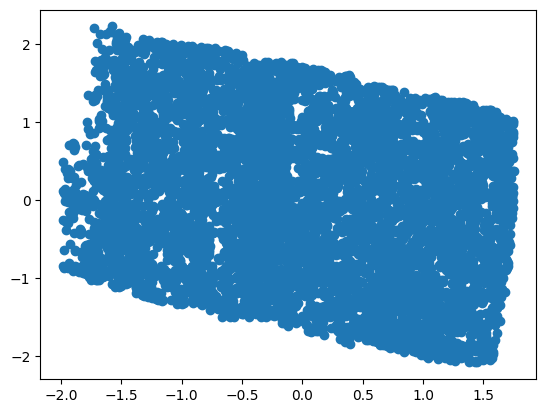

In [35]:
import matplotlib.pyplot as plt
plt.scatter(adata.obsm['spatial'][:, 0].T, adata.obsm['spatial'][:, 1].T)

In [1]:
import torch
data = torch.load("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/sea_with_pos.pt", weights_only=False)

In [11]:
for i in data:
    print(i.keys())

['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_index', 'center_coord', 'biomarker_expression', 'cell_id', 'cell_type', 'voronoi_polygon', 'edge_type', 'distance', 'y']
['num_nodes', 'cell_types', 'X', 'edge_i

In [3]:
import torch
import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
var = pd.Index(pd.read_csv("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich.csv")["Unnamed: 0"])
pt_files = sorted(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/yang_hartwich_placenta/02*"))
for i, file in tqdm(enumerate(pt_files)):
    # patient_c = file.split("/")[-1].split("_")[1]
    slide_name = file.split("/")[-1][:-3]
    graphs = torch.load(file, weights_only=False)
    graphs[0].label = 0
    torch.save(graphs, file)
    X = []
    for k in range(1, len(graphs)):
        X.append(graphs[k].X.squeeze(1).tolist())
    pos = graphs[0].X.float().numpy()
    X = np.array(X)
    adata = anndata.AnnData(X)
    adata.obsm['spatial'] = pos
    adata.var.index = var
    # adata.obs['cell_type'] = graphs[0].cell_type
    # adata.uns['reccurence'] = graphs[0].recurrence
    adata.uns['label'] = 0
    adata.write_h5ad("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/"+slide_name+".h5ad")

73it [00:35,  2.04it/s]


In [ ]:
adata_files = sorted(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/04*"))
for i, file in tqdm(enumerate(pt_files)):
    # patient_c = file.split("/")[-1].split("_")[1]
    # slide_name = file.split("/")[-1][:-3]
    # graphs = torch.load(file, weights_only=False)
    # graphs[0].label = 0
    # torch.save(graphs, file)
    # X = []
    # for k in range(1, len(graphs)):
    #     X.append(graphs[k].X.squeeze(1).tolist())
    # pos = graphs[0].X.float().numpy()
    # X = np.array(X)
    # adata = anndata.AnnData(X)
    # adata.obsm['spatial'] = pos
    # adata.var.index = var
    # adata.obs['cell_type'] = graphs[0].cell_type
    # adata.uns['reccurence'] = graphs[0].recurrence
    adata = anndata.read_h5ad(file)
    adata.uns['label'] = 0
    adata.write_h5ad(file)

0it [00:00, ?it/s]


OSError: Unable to synchronously open file (file signature not found)

In [9]:
adata_files = sorted(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07*"))
adata_files

['/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07012342.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07012424.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07012431.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07012432.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013222.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013223.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013241.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013334.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013344.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/placenta/07013441.h5ad',
 '/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/da

In [8]:
max_idx = 0
max_size = 0
import anndata 
from glob import glob
for i,v in enumerate(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/upmc/*")):
    adata = anndata.read_h5ad(v)
    if(max_size<adata.n_obs):
        max_idx = i
        max_size = adata.n_obs
print(glob("/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/upmc/*")[max_idx])

/gpfs/gibbs/pi/krishnaswamy_smita/hm638/SCGFM/data/raw_counts_adata/upmc/UPMC_c006_v001_r001_reg019.h5ad


In [9]:
max_size

19826